## Sentence Transformation and Embeddings

### Initialization

#### Acknowledgements

- https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2
- https://www.kaggle.com/datasets/zarajamshaid/language-identification-datasst
- https://danielmuellerkomorowska.com/2021/01/05/introduction-to-t-sne-in-python-with-scikit-learn/
- https://towardsdatascience.com/understanding-k-means-k-means-and-k-medoids-clustering-algorithms-ad9c9fbf47ca

#### Packages

In [1]:
import sentence_transformers as pkg_sentence_transformers
import scipy.spatial.distance as pkg_distance
import pandas as pkg_pandas
import sklearn.model_selection as pkg_model_selection
import sklearn.manifold as pkg_manifold
import sklearn.metrics as pkg_metrics
import sklearn.cluster as pkg_cluster
import matplotlib.pyplot as pkg_plot
import seaborn as pkg_seaborn


#### Common

In [2]:
%matplotlib inline
model_path = 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
model = pkg_sentence_transformers.SentenceTransformer(model_path)


### Play: Find Similar Sentences

#### Load Data

In [3]:
baseline_df = pkg_pandas.read_csv("../data/kaggle/datasets/wikipedia-language-identification-2018.csv.gz", compression='gzip', on_bad_lines='skip')
baseline_df.head()

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch


In [4]:
baseline_df = baseline_df[baseline_df["language"] == "English"]
baseline_df

,Text,language
37,in johnson was awarded an american institute ...,English
40,bussy-saint-georges has built its identity on ...,English
76,minnesotas state parks are spread across the s...,English
90,nordahl road is a station served by north coun...,English
97,a talk by takis fotopoulos about the internati...,English
...,...,...
21829,on march empty mirrors press published epste...,English
21879,he [musk] wants to go to mars to back up human...,English
21896,overall the male is black above and white belo...,English
21897,tim reynolds born december in wiesbaden germ...,English


In [5]:
# Configuration Options

# This dataset contains 1000 data points, sample size of 20% means roughly 200 data points
sample_size = 20

# Maximum allowed cosine distance (or Minimum Similarity) %age
max_cosine_distance = 40

# Text Column Name
text_column_name = "Text"

In [6]:
# Use Train-Test Splitter to randomly pick the required sample size
train_df, test_df = pkg_model_selection.train_test_split(baseline_df, train_size=sample_size/100)
baseline_df.shape, train_df.shape, test_df.shape

((1000, 2), (200, 2), (800, 2))

In [7]:
# Persist the train samples as these are the ones we refer to using an index
train_df.to_csv("../.outputs/.datasets/wikipedia-english-language-sample-sentences.csv", index=False)

#### Process

**Calculate Sentence Embeddings**

In [8]:
# Calculate Sentence Embeddings
# (Assume order is preserved)
text_embeddings = model.encode(train_df[text_column_name].array)
text_embeddings.shape

(200, 768)

**Plot Embeddings**

In [9]:
# Plot the embeddings/vectors

# Reduce the high-dimensional vectors (768) to low-dimensional vectors (2) using t-SNE
tsne = pkg_manifold.TSNE(2)
tsne_result = tsne.fit_transform(text_embeddings)
tsne_result.shape

/home/raooruga/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/raooruga/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(200, 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


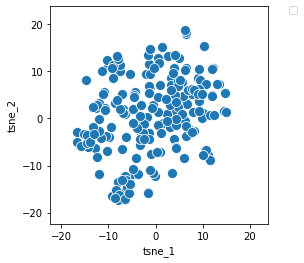

In [10]:
column_name_x = "tsne_1"
column_name_y = "tsne_2"

train_df[column_name_x] = tsne_result[:,0]
train_df[column_name_y] = tsne_result[:,1]

# Plot the result of our TSNE with the label color coded
fig, ax = pkg_plot.subplots(1)
pkg_seaborn.scatterplot(x=column_name_x, y=column_name_y, data=train_df, ax=ax, s=100)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.0)

**Cluster Sentences: Find Cluster Count**

_Notes_:
- From the graph/plot picture, it is not easy to identify the optimal no. of clusters. So, go for elbow detection 

In [11]:
# Sum of Square Errors (sse)
sse = []

cluster_count_range = range(1, int(len(train_df)/2))

for cluster_count in cluster_count_range:
    kmt = pkg_cluster.KMeans(n_clusters=cluster_count)
    kmt.fit(train_df[[column_name_x,column_name_y]])
    sse.append(kmt.inertia_)

sse[0:5]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[26542.072265625,
 14374.15625,
 9670.2841796875,
 7301.68896484375,
 5573.53955078125]

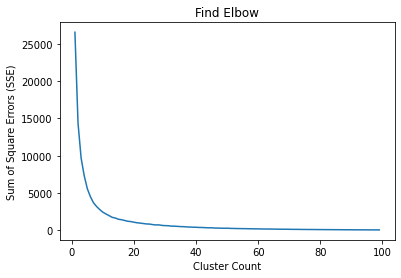

In [12]:
pkg_plot.title("Find Elbow")
pkg_plot.xlabel("Cluster Count")
pkg_plot.ylabel("Sum of Square Errors (SSE)")
pkg_plot.plot(cluster_count_range, sse)

**Cluster Sentences: Create Clusters and Draw Clusters**

In [13]:
cluster_count = 12 # Based on the elbow graph above

km = pkg_cluster.KMeans(n_clusters=cluster_count)
predicted_clusters = km.fit_predict(train_df[[column_name_x, column_name_y]])
train_df["cluster_number"] = predicted_clusters
train_df.head()

,Text,language,tsne_1,tsne_2,cluster_number
6104,the delta goodrem unreleased tapes dispute inv...,English,13.377821,7.378987,11
13412,st place in general excellence freedom of info...,English,11.030655,-7.748358,9
10514,when kent was a youth australia had no nationw...,English,14.656881,5.359017,11
2185,skörstorp church swedish skörstorps kyrka is a...,English,-9.991615,-3.934872,5
14263,following a january announcement page officia...,English,-10.094995,10.869231,2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


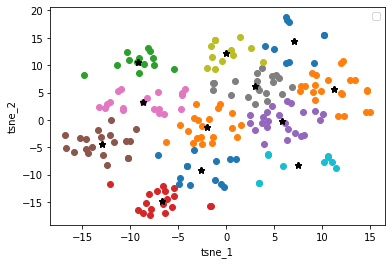

In [14]:
pkg_plot.xlabel(column_name_x)
pkg_plot.ylabel(column_name_y)
pkg_plot.legend()

for i in range(cluster_count):
    cluster_df = train_df[train_df["cluster_number"] == i]
    pkg_plot.scatter(cluster_df[column_name_x], cluster_df[column_name_y], marker='o')    
    pkg_plot.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], color='black', marker='*')

**Calculate Distances/Similarities**

In [15]:
# Calculate Distances/Similarities
similarites_df = pkg_pandas.DataFrame(columns=["text_index_1", "text_index_2", "cosine_distance", "euclidean_distance"])

for i in range(0, len(text_embeddings)):
    for j in range(i+1, len(text_embeddings)):
        cosine_distance = pkg_distance.cosine(text_embeddings[i], text_embeddings[j])
        euclidean_distance = pkg_distance.euclidean(text_embeddings[i], text_embeddings[j])
        similarites_df.loc[len(similarites_df)] = [i, j, cosine_distance, euclidean_distance]

similarites_df.head()

,text_index_1,text_index_2,cosine_distance,euclidean_distance
0,0.0,1.0,0.854828,3.631072
1,0.0,2.0,0.628076,3.018969
2,0.0,3.0,0.959184,3.876464
3,0.0,4.0,0.893406,3.714833
4,0.0,5.0,0.815832,3.457708


In [16]:
# Filter rows that have less than maximum allowed cosine distance
similarites_df = similarites_df[(similarites_df["cosine_distance"] < (max_cosine_distance/100))]
similarites_df.head()

,text_index_1,text_index_2,cosine_distance,euclidean_distance
271,1.0,74.0,0.359338,2.285488
288,1.0,91.0,0.315424,2.138572
321,1.0,124.0,0.344820,2.297021
579,2.0,185.0,0.341049,2.179261
613,3.0,23.0,0.317650,2.255119


In [17]:
# Sort using similarity
similarites_df.sort_values(by=["cosine_distance", "euclidean_distance"], ascending=True, inplace=True)
similarites_df.to_csv("../.outputs/.datasets/wikipedia-english-language-similar_sentences.csv", index=False)
similarites_df.head()

,text_index_1,text_index_2,cosine_distance,euclidean_distance
12041,74.0,91.0,0.061135,0.890861
6278,34.0,108.0,0.104425,1.180831
12539,78.0,99.0,0.148925,1.503891
13825,89.0,120.0,0.217421,1.856058
17393,128.0,178.0,0.234348,1.844208
